In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
import re

import numpy as np
import matplotlib.pyplot as plt

In [2]:
regex_params = r'Candidate\(args=\((\d+(\.\d*)?|\.\d+), (\d+(\.\d*)?|\.\d+), (\d+(\.\d*)?|\.\d+), (\d+(\.\d*)?|\.\d+)'
regex_fitness = r'Updating fitness with value (\d+(\.\d*)?|\.\d+)'
regex_mean = r'mean: (\d+(\.\d*)?|\.\d+)'
regex_gamma = r'Gamma factor: (\d+(\.\d*)?|\.\d+)'

In [3]:
def parse_file(path, regex_params, regex_fitness, regex_mean, regex_gamma):
    params = []
    fitness = []
    mean = []
    gamma = []
    
    f = os.path.join(os.environ.get('MSC_PROJECT'), path)
    with open(f, 'r') as fh:
        lines = fh.readlines() 

    for line in lines:
        matches_params = re.search(regex_params, line)
        matches_fitness = re.search(regex_fitness, line)
        matches_mean = re.search(regex_mean, line)
        matches_gamma = re.search(regex_gamma, line)
        
        if matches_params:
            x = [float(i) for i in matches_params.group(1,3,5,7)]
            params.append(x)
        if matches_fitness:
            fitness.append(float(matches_fitness.group(1)))
        if matches_mean:
            mean.append(float(matches_mean.group(1)))
        if matches_gamma:
            gamma.append(float(matches_gamma.group(1)))
            
    params = np.array(params)
    fitness = np.array(fitness)
    mean = np.array(mean)
    gamma = np.array(gamma)
    
    return params, fitness, mean, gamma

In [4]:
DE_p, DE_f, DE_m, DE_g = parse_file('optimisation_scripts/outputs/TL2_DE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
PSO_p, PSO_f, PSO_m, PSO_g = parse_file('optimisation_scripts/outputs/TL2_PSO_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_p, TPDE_f, TPDE_m, TPDE_g = parse_file('optimisation_scripts/outputs/TL2_TPDE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
SQP_p, SQP_f, SQP_m, SQP_g = parse_file('optimisation_scripts/outputs/TL2_SQP_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)

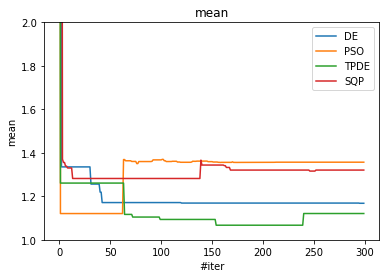

In [5]:
plt.plot(DE_m, label='DE')
plt.plot(PSO_m, label='PSO')
plt.plot(TPDE_m, label='TPDE')
plt.plot(SQP_m, label='SQP')
plt.ylim(1,2)
plt.title('mean')
plt.ylabel('mean')
plt.xlabel('#iter')
plt.legend()
plt.savefig('../../mean.pdf')
plt.show()


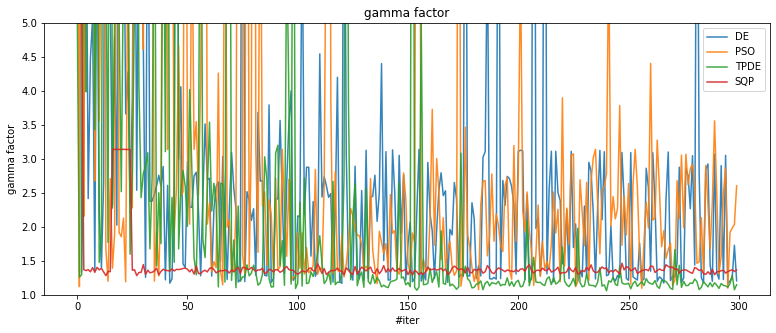

In [6]:
alpha = 0.9


plt.figure(figsize=(13,5))

plt.plot(DE_g, label='DE', alpha=alpha)
plt.plot(PSO_g, label='PSO', alpha=alpha)
plt.plot(TPDE_g, label='TPDE', alpha=alpha)
plt.plot(SQP_g, label='SQP', alpha=alpha)
plt.ylim(1,5)
plt.title('gamma factor')
plt.ylabel('gamma factor')
plt.xlabel('#iter')
plt.legend()
plt.savefig('../../gamma.pdf')
plt.show()



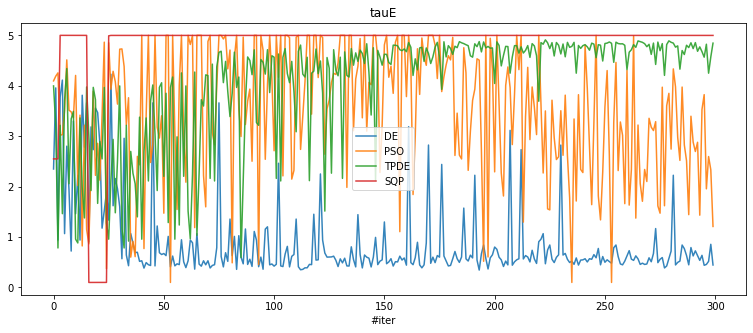

In [7]:
alpha = 0.9
plt.figure(figsize=(13,5))

plt.plot(DE_p[:,0],label='DE', alpha=alpha)
plt.plot(PSO_p[:,0],label='PSO', alpha=alpha)
plt.plot(TPDE_p[:,0],label='TPDE', alpha=alpha)
plt.plot(SQP_p[:,0],label='SQP', alpha=alpha)

plt.legend()
plt.xlabel('#iter')
plt.title('tauE')
plt.savefig('../../tauE.pdf')
plt.show()

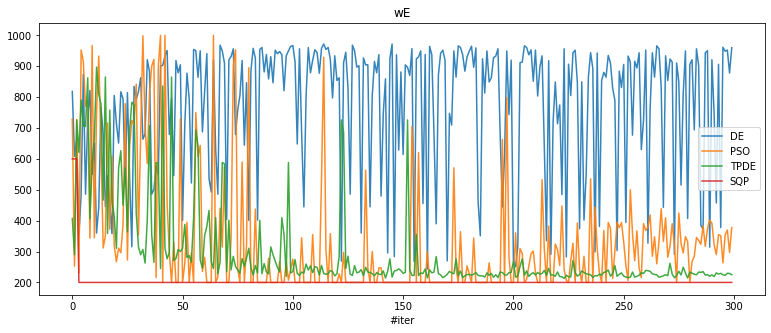

In [8]:
alpha = 0.9
plt.figure(figsize=(13,5))

plt.plot(DE_p[:,1],label='DE', alpha=alpha)
plt.plot(PSO_p[:,1],label='PSO', alpha=alpha)
plt.plot(TPDE_p[:,1],label='TPDE', alpha=alpha)
plt.plot(SQP_p[:,1],label='SQP', alpha=alpha)

plt.legend()
plt.xlabel('#iter')
plt.title('wE')
#plt.savefig('../../wE.pdf')
plt.show()

In [9]:
print('DE')
print(f'tauE mean {DE_p[:,0].mean():.4f} - std {DE_p[:,0].std():.4f}')
print(f'wE mean {DE_p[:,1].mean():.4f} - std {DE_p[:,1].std():.4f}')

print('TPDE')
print(f'tauE mean {TPDE_p[:,0].mean():.4f} - std {TPDE_p[:,0].std():.4f}')
print(f'wE mean {TPDE_p[:,1].mean():.4f} - std {TPDE_p[:,1].std():.4f}')

print('PSO')
print(f'tauE mean {PSO_p[:,0].mean():.4f} - std {PSO_p[:,0].std():.4f}')
print(f'wE mean {PSO_p[:,1].mean():.4f} - std {PSO_p[:,1].std():.4f}')

print('SQP')
print(f'tauE mean {SQP_p[:,0].mean():.4f} - std {SQP_p[:,0].std():.4f}')
print(f'wE mean {SQP_p[:,1].mean():.4f} - std {SQP_p[:,1].std():.4f}')

DE
tauE mean 0.8879 - std 0.7935
wE mean 769.2316 - std 213.4216
TPDE
tauE mean 4.0311 - std 1.1112
wE mean 300.0034 - std 151.7583
PSO
tauE mean 3.4942 - std 1.2845
wE mean 341.3392 - std 202.6417
SQP
tauE mean 4.8273 - std 0.8663
wE mean 204.0369 - std 39.7958


In [12]:
print(np.argmin(TPDE_g), np.min(TPDE_g))
print(TPDE_p[np.argmin(TPDE_g),0], TPDE_p[np.argmin(TPDE_g),1])
# Different from reccomended value

240 1.0587939629259298
4.795883117624392 223.8756599776671
